# Introduction

UNet is dedicated to solving this problem. The reason it is able to localise and distinguish borders is by doing classification on every pixel, so the input and output share the same size.


# Workflow

The models are used here are modified U-Nets. A U-Net consists of an encoder (downsampler) and decoder (upsampler).

**Resnet50**

**densenet121**

**Mobilenetv2**

# Imports

In [ ]:
!pip install segmentation_models
!pip install tensorflow==2.9.1
!!pip install -q git+https://github.com/tensorflow/examples.git


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
import segmentation_models as sm
AUTOTUNE = tf.data.AUTOTUNE
from keras.metrics import MeanIoU
import tensorflow_datasets as tfds

# Data Processing and visualization

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:


def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


def load_image(datapoint, cat = True):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
    )
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


def normalize_cat(input_image, input_mask):

    input_image = tf.cast(input_image, tf.float32) / 255.0

    input_mask = tf.reshape(input_mask, [128, 128])
    input_mask = tf.one_hot(tf.cast(input_mask, tf.int32), 3)
    input_mask = tf.cast(input_mask, tf.float32)
    return input_image, input_mask

def load_image2(datapoint, cat = True):      #for one-hot encoded
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
    )
    input_image, input_mask = normalize_cat(input_image, input_mask)

    return input_image, input_mask


In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
train_batches = (
    train_images
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)



In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
for images, masks in test_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# Creating Models

In [ ]:
! pip install gdown

In [ ]:
#loss functions

entropy_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)  #Here I have used entropy loss, feel free to use other loss functions as well such as dice loss or focal loss
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5 for i in range(0,3)]))  #while using dice and focal loss the pixel values of Y (that means the mask ) must be one-hot encoded
focal_loss = sm.losses.CategoricalFocalLoss()

"""
while using dice loss and focal loss the value of the pixels in the mask must be one-hot encoded , use the load_image2 function for data proessing

hybrid losses can also be used, most of the cases it gives better results

hybrid_losses1 = focal_loss + (3 * dice_loss)

hybrid_losses2 = (2 * focal_loss) + (1.7 * dice_loss)

hybrid_losses2 = ((focal_loss) + (dice_loss))/2

the constant value are arbitary in the hybrid loss


"""


metrics = ["accuracy",sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


input_shape = (128,128,3)
epochs = 15


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape = input_shape , n = 3 ,  lr = 0.0001 , loss = entropy_loss , metrics = metrics ):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    resnet50.layers[0]._name  = "input_1"

    resnet50._name = "Resnet50"

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output
    s2 = resnet50.get_layer("conv1_relu").output
    s3 = resnet50.get_layer("conv2_block3_out").output
    s4 = resnet50.get_layer("conv3_block4_out").output

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(n, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr) ,loss = loss , metrics = metrics)
    return model



def build_densenet121_unet(input_shape = input_shape, n = 3 , lr = 0.0001 , loss = entropy_loss , metrics = metrics ):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained DenseNet121 Model """
    densenet =  tf.keras.applications.DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    densenet.layers[0]._name  = "input_1"

    densenet._name = "Densenet121"

    """ Encoder """
    s1 = densenet.get_layer("input_1").output
    s2 = densenet.get_layer("conv1/relu").output
    s3 = densenet.get_layer("pool2_relu").output
    s4 = densenet.get_layer("pool3_relu").output

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Outputs """
    outputs = Conv2D(n, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr) ,loss = loss , metrics = metrics)
    return model


def build_mobilenetv2_unet(input_shape = input_shape, n = 3 ,  lr = 0.0001 , loss = entropy_loss , metrics = metrics):
    """ Input """
    inputs = Input(shape=input_shape)

    """ Pre-trained MobileNetV2 """
    encoder = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet",
        input_tensor=inputs)

    encoder.layers[0]._name  = "input_1"

    encoder._name = "Mobilenetv2"

    """ Encoder """
    s1 = encoder.get_layer("input_1").output
    s2 = encoder.get_layer("block_1_expand_relu").output
    s3 = encoder.get_layer("block_3_expand_relu").output
    s4 = encoder.get_layer("block_6_expand_relu").output

    """ Bridge """
    b1 = encoder.get_layer("block_13_expand_relu").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(n, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="MobileNetV2_U-Net")
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr) ,loss = loss , metrics = metrics)
    return model


#Using Resnet as The encoder

#pre trained models weight
paths = {

    "resnet" : "https://drive.google.com/uc?/export=download&id=1n6S59Ec84oNGmny05S-ZiOIuJlawu5oP",

    "densenet" : "https://drive.google.com/uc?/export=download&id=1qi4xrNX3WbhxkYoW9F9LuFvX7_9Vsh7s",

    "mobilenet": "https://drive.google.com/uc?/export=download&id=1bJjW4-p6qll2BtmZ9GPgvsqxn4j3KQk0"

}

import gdown
import os

def training_model(model_name,train_batches = None,test_batches = None ,epochs = 20,train = False):

    if(model_name == "resnet"):

        model = build_resnet50_unet()

    elif(model_name == "densenet" ):

        model = build_densenet121_unet()

    else:

        model = build_mobilenetv2_unet()


    if(train):

        model.fit(train_batches,
                    validation_data = test_batches,
                    epochs=epochs)

    else:

        gdown.download(paths[model_name])

        base = os.getcwd()

        model_path = os.path.join(base,model_name + ".h5")


        model.load_weights(model_path)

    return model






model_resnet = training_model("resnet")

model_densenet = training_model("densenet")

model_mobilenet = training_model("mobilenet")

# Visualization of results

In [ ]:
def create_mask(pred_mask):

    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(model,num=5):

    for image, mask in test_batches.take(num):

        pred_mask = model.predict(image[:1])
        display([image[0], mask[0], create_mask(pred_mask)])


In [ ]:
## Visualization Resnet50 Encoder


show_predictions(model_resnet)

In [ ]:
# Visualization Densenet121 Encoder


show_predictions(model_densenet)

In [ ]:
# Visualization Mobilenetv2 Encoder


show_predictions(model_mobilenet)

# Mean iou score

In [ ]:
def convert_to_numpy(data = test_batches ):

    ds_numpy = tfds.as_numpy(data)
    X = []
    y = []
    for img_batch, mask_batch in ds_numpy:


        #not using the entire validation data , for computing the mean iou score
        #for using entire validation data replace n = 4 to n = len(img_batch)
        n = 4
        for i in range(0,n):

            X.append(img_batch[i])
            y.append(mask_batch[i])



    X = np.array(X)
    y = np.array(y)

    print("X.shape " , X.shape)
    print("y.shape " , y.shape)

    return X,y



def pred(X,y,model,num):
  #returns the y preds and y accutual

  y_acc = []
  y_pred = []
  for i in range(0,num):
    y_acc.append(y[i])
    y_pred.append(create_mask(model.predict(X[i:i+1] , verbose = 0 )) )

  y_acc = np.array(y_acc)
  y_pred = np.array(y_pred)

  print(y_acc.shape , y_pred.shape)

  return (y_acc,y_pred)




def mean_iou_score(model,X_val,y_val,n_classes = 3 ):


    X_val,y_val = convert_to_numpy()

    y_acc , y_pred = pred(X_val,y_val,model , len(y_val))
    IOU_ref = MeanIoU(num_classes=n_classes)
    IOU_ref.update_state(y_acc , y_pred)

    print("Mean iou score ", IOU_ref.result().numpy())

X_val,y_val = convert_to_numpy()

In [ ]:
#Mean IOU Score on Resnet50


mean_iou_score(model_resnet,X_val,y_val)

In [ ]:
#Mean IOU Score on Densenet121


mean_iou_score(model_densenet,X_val,y_val)

In [ ]:
#Mean IOU Score on Mobilenetv2


mean_iou_score(model_mobilenet,X_val,y_val)

# Ensemble of the 3 unets

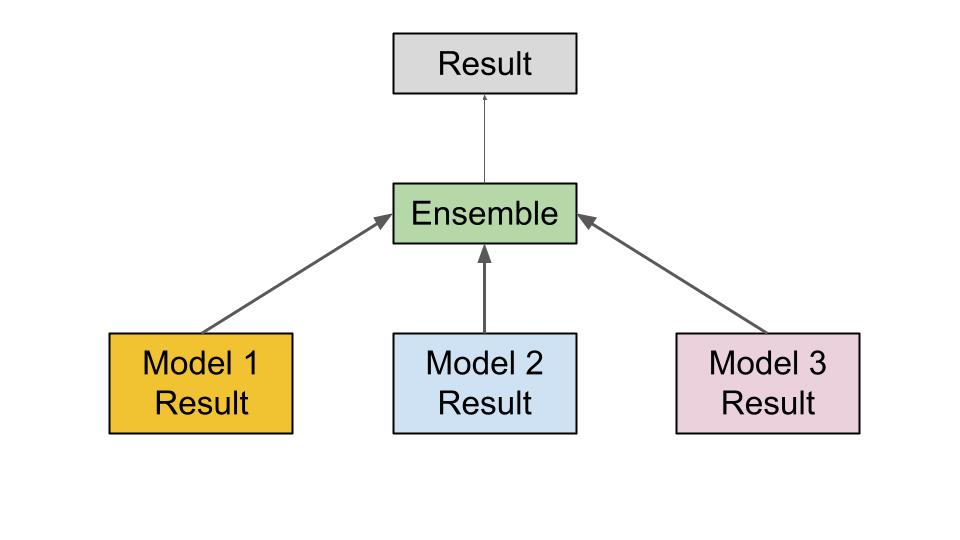

As the image shows the outputs of the three models are combined to increse the mean-iou score, as the network output the probabilities of each class of every pixel, the method will add those probabilities by a weighted sum manner, and later took that class which contains the higest probality

In [ ]:
def ensemble(model1,model2,model3,X_test,y_test,n_classes = 59):


  pred1 = model1.predict(X_test , verbose = 0 )
  pred2 = model2.predict(X_test , verbose = 0 )
  pred3 = model3.predict(X_test , verbose = 0 )

  preds=np.array([pred1, pred2, pred3])



  weights = [0.3, 0.9, 0.5]

  weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
  weighted_ensemble_prediction = np.argmax(weighted_preds, axis=3)



  print()
  print("________________________________________________________________")
  print("weighted ensemble " )
  IOU_weighted = MeanIoU(num_classes=n_classes)
  IOU_weighted.update_state(y_test, weighted_ensemble_prediction)
  print('IOU Score for weighted average ensemble = ', IOU_weighted.result().numpy())

  print("________________________________________________________________")
  print()

  for i in range(0,10):

    display([X_test[i] , y_test[i] , weighted_ensemble_prediction[i].reshape(128,128,1)])

In [ ]:
ensemble(model_resnet,model_densenet,model_mobilenet,X_val,y_val)

# Conclusion

It is seen that the Mean Iou score after ensemble Increases, previously highest Mean IoU score was 0.746 ,now it has become 0.760



# Future work


1.   Using different loss functions like focal loss, dice loss or some kind of hybrid loss, as these loss funtions are more used in segmentation problems
2.   Using diffrent pretrained encoders can lead to better results





# References

*   [Ensemble of U-nets](https://github.com/bnsreenu/python_for_microscopists/blob/master/214_multiclass_Unet_sandstone_segm_models_ensemble.py)


*   [pretrained encoders](https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/tree/main/TensorFlow)
